=== 消融实验：单模态与多模态情感分类对比 ===

1. 加载验证集数据...
验证集大小: 400
验证集标签分布: {np.int64(0): np.int64(119), np.int64(1): np.int64(42), np.int64(2): np.int64(239)}

2. 加载验证集特征...
验证集文本特征形状: (400, 2000)
验证集图像特征形状: (400, 2048)
验证集融合特征形状: (400, 512)

3. 加载多模态融合模型...

4. 训练单模态模型...
训练集文本特征形状: (3600, 2000)
训练集图像特征形状: (3600, 2048)
训练集标签形状: (3600,)

训练文本单模态模型...
文本单模态模型训练完成

训练图像单模态模型...
图像单模态模型训练完成

5. 在验证集上进行预测...
预测完成

6. 评估模型性能...

文本单模态 模型评估结果:
  准确率: 0.5475
  加权F1分数: 0.5573
  宏平均F1分数: 0.4339

文本单模态 分类报告:
              precision    recall  f1-score   support

    negative       0.45      0.44      0.44       119
     neutral       0.15      0.21      0.18        42
    positive       0.70      0.66      0.68       239

    accuracy                           0.55       400
   macro avg       0.43      0.44      0.43       400
weighted avg       0.57      0.55      0.56       400


图像单模态 模型评估结果:
  准确率: 0.5900
  加权F1分数: 0.5907
  宏平均F1分数: 0.4862

图像单模态 分类报告:
              precision    recall  f1-score   suppo

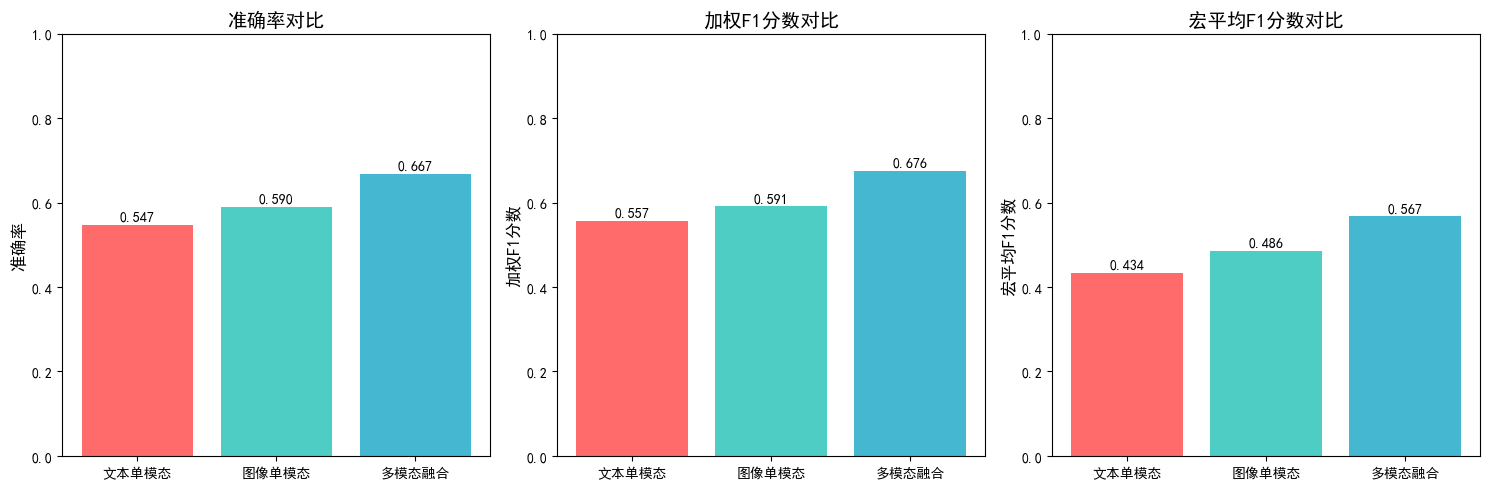


8. 可视化混淆矩阵...


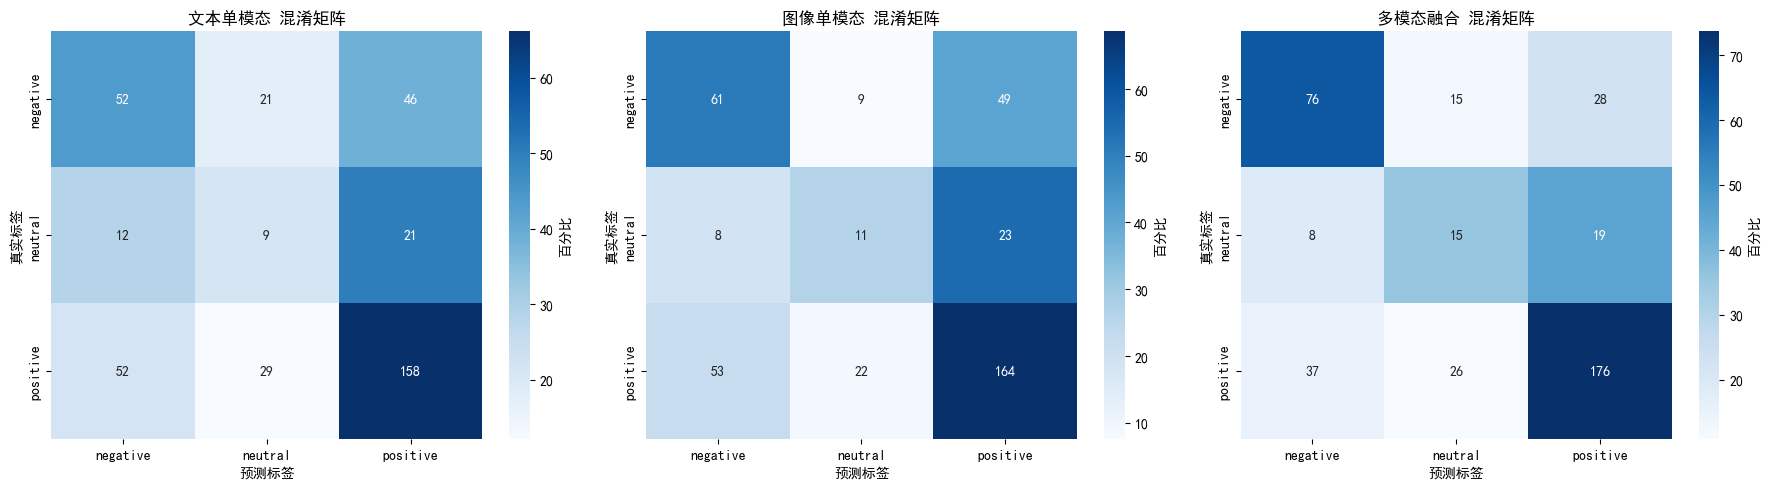


9. 分析各类别性能...


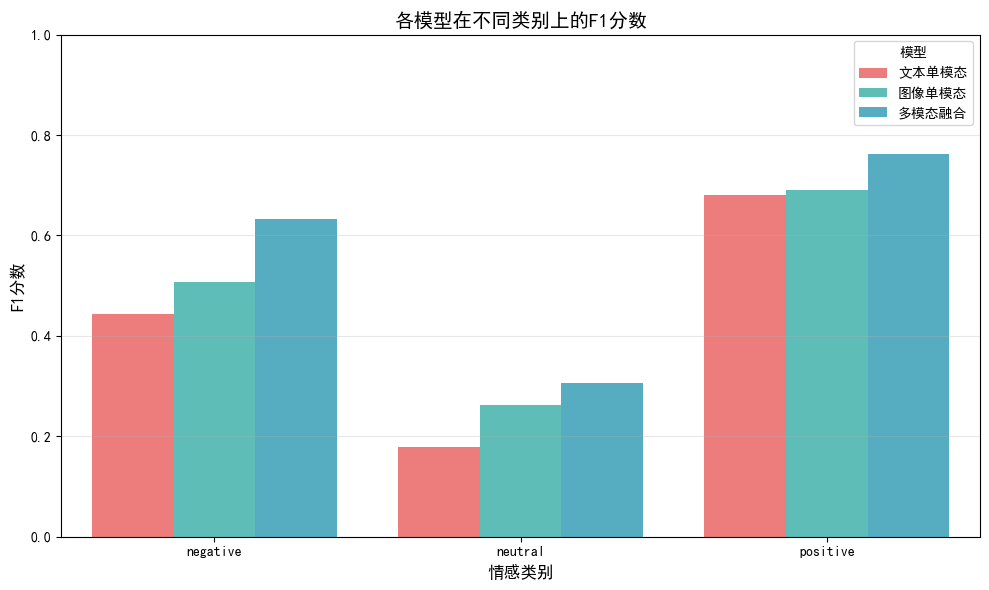


各类别性能详情:
模型         图像单模态   多模态融合   文本单模态
类别                              
negative  0.5062  0.6333  0.4426
neutral   0.2619  0.3061  0.1782
positive  0.6905  0.7619  0.6810

10. 保存单模态模型...
文本单模态模型已保存到: ./data/models/text_only_model.pkl
图像单模态模型已保存到: ./data/models/image_only_model.pkl

11. 生成消融实验报告...
消融实验报告已保存到: ./data/splits/ablation_report.txt

=== 消融实验报告 ===

实验目的：比较单模态（仅文本、仅图像）与多模态融合模型在情感分类任务上的性能。

数据集信息：
- 训练集大小: 3600
- 验证集大小: 400
- 标签分布（验证集）: negative=119, neutral=42, positive=239

模型配置：
- 所有模型使用逻辑回归分类器
- 参数: max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs', class_weight='balanced'
- 文本特征维度: 2000
- 图像特征维度: 2048
- 融合特征维度: 512

性能对比：

   模型    准确率   加权F1分数  宏平均F1分数
文本单模态 0.5475 0.557291 0.433935
图像单模态 0.5900 0.590691 0.486218
多模态融合 0.6675 0.675798 0.567120

关键发现：
1. 文本单模态模型的准确率为 0.5475
2. 图像单模态模型的准确率为 0.5900
3. 多模态融合模型的准确率为 0.6675
4. 多模态融合相比文本单模态性能提升: 12.00%
5. 多模态融合相比图像单模态性能提升: 7.75%

生成时间: 2026-01-28 14:27:51


=== 消融实验完成 ===
生成的文件:
1. 单模态模型: ./data/mode

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import joblib
import pickle
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("=== 消融实验：单模态与多模态情感分类对比 ===")

# 1. 加载数据
print("\n1. 加载验证集数据...")

# 加载标签编码器
train_df = pd.read_csv('./data/splits/train_dataset.csv')
all_labels = train_df['tag'].unique()

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# 加载验证集标签
val_df = pd.read_csv('./data/splits/val_dataset.csv')
val_labels = label_encoder.transform(val_df['tag'])

print(f"验证集大小: {len(val_df)}")
print(f"验证集标签分布: {dict(zip(*np.unique(val_labels, return_counts=True)))}")

# 2. 加载特征
print("\n2. 加载验证集特征...")

fusion_dir = './data/splits/fusion'

# 加载文本特征
val_text_norm = np.load(os.path.join(fusion_dir, 'val_text_norm.npy'))
print(f"验证集文本特征形状: {val_text_norm.shape}")

# 加载图像特征
val_image_norm = np.load(os.path.join(fusion_dir, 'val_image_norm.npy'))
print(f"验证集图像特征形状: {val_image_norm.shape}")

# 加载融合特征
val_fused_norm = np.load(os.path.join(fusion_dir, 'val_fused.npy'))
print(f"验证集融合特征形状: {val_fused_norm.shape}")

# 3. 加载多模态融合模型
print("\n3. 加载多模态融合模型...")
multimodal_model = joblib.load('./data/models/baseline_logistic_quick.pkl')

# 4. 训练单模态模型
print("\n4. 训练单模态模型...")

# 加载训练集特征用于训练单模态模型
train_text_norm = np.load(os.path.join(fusion_dir, 'train_text_norm.npy'))
train_image_norm = np.load(os.path.join(fusion_dir, 'train_image_norm.npy'))
train_labels = np.load(os.path.join(fusion_dir, 'train_labels.npy'))

print(f"训练集文本特征形状: {train_text_norm.shape}")
print(f"训练集图像特征形状: {train_image_norm.shape}")
print(f"训练集标签形状: {train_labels.shape}")

# 训练文本单模态模型
print("\n训练文本单模态模型...")
text_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'
)
text_model.fit(train_text_norm, train_labels)
print("文本单模态模型训练完成")

# 训练图像单模态模型
print("\n训练图像单模态模型...")
image_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'
)
image_model.fit(train_image_norm, train_labels)
print("图像单模态模型训练完成")

# 5. 在验证集上进行预测
print("\n5. 在验证集上进行预测...")

# 文本单模态预测
text_predictions = text_model.predict(val_text_norm)
text_probs = text_model.predict_proba(val_text_norm)

# 图像单模态预测
image_predictions = image_model.predict(val_image_norm)
image_probs = image_model.predict_proba(val_image_norm)

# 多模态融合预测
multimodal_predictions = multimodal_model.predict(val_fused_norm)
multimodal_probs = multimodal_model.predict_proba(val_fused_norm)

print("预测完成")

# 6. 评估模型性能
print("\n6. 评估模型性能...")

def evaluate_model(name, predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    f1_weighted = f1_score(true_labels, predictions, average='weighted')
    f1_macro = f1_score(true_labels, predictions, average='macro')
    
    print(f"\n{name} 模型评估结果:")
    print(f"  准确率: {accuracy:.4f}")
    print(f"  加权F1分数: {f1_weighted:.4f}")
    print(f"  宏平均F1分数: {f1_macro:.4f}")
    
    # 显示分类报告
    print(f"\n{name} 分类报告:")
    print(classification_report(true_labels, predictions, 
                                target_names=['negative', 'neutral', 'positive']))
    
    return {
        'name': name,
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'predictions': predictions,
        'true_labels': true_labels
    }

# 评估三个模型
results = []
results.append(evaluate_model("文本单模态", text_predictions, val_labels))
results.append(evaluate_model("图像单模态", image_predictions, val_labels))
results.append(evaluate_model("多模态融合", multimodal_predictions, val_labels))

# 7. 可视化比较结果
print("\n7. 可视化比较结果...")

# 创建比较表格
comparison_df = pd.DataFrame({
    '模型': [r['name'] for r in results],
    '准确率': [r['accuracy'] for r in results],
    '加权F1分数': [r['f1_weighted'] for r in results],
    '宏平均F1分数': [r['f1_macro'] for r in results]
})

print("\n模型性能比较:")
print(comparison_df.to_string(index=False))

# 可视化性能对比
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 准确率对比
axes[0].bar(comparison_df['模型'], comparison_df['准确率'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('准确率对比', fontsize=14)
axes[0].set_ylabel('准确率', fontsize=12)
axes[0].set_ylim([0, 1])
for i, v in enumerate(comparison_df['准确率']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# 加权F1分数对比
axes[1].bar(comparison_df['模型'], comparison_df['加权F1分数'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('加权F1分数对比', fontsize=14)
axes[1].set_ylabel('加权F1分数', fontsize=12)
axes[1].set_ylim([0, 1])
for i, v in enumerate(comparison_df['加权F1分数']):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

# 宏平均F1分数对比
axes[2].bar(comparison_df['模型'], comparison_df['宏平均F1分数'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[2].set_title('宏平均F1分数对比', fontsize=14)
axes[2].set_ylabel('宏平均F1分数', fontsize=12)
axes[2].set_ylim([0, 1])
for i, v in enumerate(comparison_df['宏平均F1分数']):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('./data/splits/ablation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 8. 混淆矩阵可视化
print("\n8. 可视化混淆矩阵...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (result, ax) in enumerate(zip(results, axes)):
    cm = confusion_matrix(result['true_labels'], result['predictions'])
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建热力图
    sns.heatmap(cm_percent, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'],
                cbar_kws={'label': '百分比'},
                ax=ax)
    
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    ax.set_title(f'{result["name"]} 混淆矩阵')

plt.tight_layout()
plt.savefig('./data/splits/ablation_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# 9. 分析各类别性能
print("\n9. 分析各类别性能...")

# 获取各类别的F1分数
category_names = ['negative', 'neutral', 'positive']
category_results = []

for model_result in results:
    model_name = model_result['name']
    predictions = model_result['predictions']
    true_labels = model_result['true_labels']
    
    # 计算每个类别的F1分数
    f1_scores = f1_score(true_labels, predictions, average=None)
    
    for i, (category, f1) in enumerate(zip(category_names, f1_scores)):
        category_results.append({
            '模型': model_name,
            '类别': category,
            'F1分数': f1
        })

category_df = pd.DataFrame(category_results)

# 可视化各类别性能
plt.figure(figsize=(10, 6))
sns.barplot(data=category_df, x='类别', y='F1分数', hue='模型', 
            palette=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('各模型在不同类别上的F1分数', fontsize=14)
plt.ylabel('F1分数', fontsize=12)
plt.xlabel('情感类别', fontsize=12)
plt.legend(title='模型')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('./data/splits/ablation_category_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n各类别性能详情:")
print(category_df.pivot(index='类别', columns='模型', values='F1分数').round(4))

# 10. 保存单模态模型
print("\n10. 保存单模态模型...")
os.makedirs('./data/models', exist_ok=True)

joblib.dump(text_model, './data/models/text_only_model.pkl')
print("文本单模态模型已保存到: ./data/models/text_only_model.pkl")

joblib.dump(image_model, './data/models/image_only_model.pkl')
print("图像单模态模型已保存到: ./data/models/image_only_model.pkl")

# 11. 生成消融实验报告
print("\n11. 生成消融实验报告...")

report = f"""
=== 消融实验报告 ===

实验目的：比较单模态（仅文本、仅图像）与多模态融合模型在情感分类任务上的性能。

数据集信息：
- 训练集大小: {len(train_labels)}
- 验证集大小: {len(val_labels)}
- 标签分布（验证集）: negative={np.sum(val_labels==0)}, neutral={np.sum(val_labels==1)}, positive={np.sum(val_labels==2)}

模型配置：
- 所有模型使用逻辑回归分类器
- 参数: max_iter=1000, random_state=42, multi_class='multinomial', solver='lbfgs', class_weight='balanced'
- 文本特征维度: {train_text_norm.shape[1]}
- 图像特征维度: {train_image_norm.shape[1]}
- 融合特征维度: {val_fused_norm.shape[1]}

性能对比：

{comparison_df.to_string(index=False)}

关键发现：
1. 文本单模态模型的准确率为 {comparison_df.loc[0, '准确率']:.4f}
2. 图像单模态模型的准确率为 {comparison_df.loc[1, '准确率']:.4f}
3. 多模态融合模型的准确率为 {comparison_df.loc[2, '准确率']:.4f}
4. 多模态融合相比文本单模态性能提升: {(comparison_df.loc[2, '准确率'] - comparison_df.loc[0, '准确率']) * 100:.2f}%
5. 多模态融合相比图像单模态性能提升: {(comparison_df.loc[2, '准确率'] - comparison_df.loc[1, '准确率']) * 100:.2f}%

生成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# 保存报告
with open('./data/splits/ablation_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("消融实验报告已保存到: ./data/splits/ablation_report.txt")

# 显示报告摘要
print(report)

print("\n=== 消融实验完成 ===")
print("生成的文件:")
print("1. 单模态模型: ./data/models/text_only_model.pkl, ./data/models/image_only_model.pkl")
print("2. 性能对比图: ./data/splits/ablation_comparison.png")
print("3. 混淆矩阵图: ./data/splits/ablation_confusion_matrices.png")
print("4. 类别性能图: ./data/splits/ablation_category_performance.png")
print("5. 实验报告: ./data/splits/ablation_report.txt")